In [1]:
# =============================
# STEP 1 - IMPORT ALL LIBRARIES
# =============================
!pip install catboost
#!pip install ydata-profiling
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,
                             precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score,
                             precision_recall_curve, mean_absolute_error)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import FactorAnalysis

# Visualization & Stats
import seaborn as sns
from statsmodels.stats.power import TTestPower
from scipy import stats
from scipy.stats import norm, spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from ydata_profiling import ProfileReport
#from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [2]:
# =============================
# STEP 2 - PROCESS INPUT DATA
# =============================

# CO2 data
co2_df = pd.read_csv(r"/content/annual-co2-emissions-per-country.csv", encoding="cp1252")
# Fix the encoding issue in the column name
co2_df.rename(
    columns={
        'Entity': 'Country',
        'Annual COâ‚‚ emissions': 'Annual CO₂ emissions'
    },
    inplace=True
)
co2_pivot = co2_df.pivot(index='Country', columns='Year', values='Annual CO₂ emissions')
co2_pivot['Delta_2013_2023'] = co2_pivot[2023] - co2_pivot[2013]
co2_delta_df = co2_pivot[[2013, 2023, 'Delta_2013_2023']].reset_index()

# World data
world_df = pd.read_csv(r"/content/world-data-2023.csv", encoding="utf-8")
world_df = world_df[['Country', 'Density\n(P/Km2)', 'Agricultural Land( %)', 'Birth Rate',
                     'Armed Forces size', 'Co2-Emissions', 'Fertility Rate',
                     'Forested Area (%)', 'GDP', 'Gross primary education enrollment (%)',
                     'Gross tertiary education enrollment (%)', 'Infant mortality',
                     'Maternal mortality ratio', 'Minimum wage',
                     'Out of pocket health expenditure', 'Physicians per thousand',
                     'Population: Labor force participation (%)', 'Tax revenue (%)',
                     'Population', 'Total tax rate', 'Unemployment rate']]
print(world_df.shape)
# Happiness data
hap_df = pd.read_csv(r"/content/World-happiness-report-2024.csv", encoding="utf-8")
hap_df.rename(columns={'Country name': 'Country'}, inplace=True)
hap_df.rename(columns={'Ladder score': 'Happiness'}, inplace=True)
hap_df = hap_df[['Country', 'Happiness', 'Regional indicator', 'Perceptions of corruption',
                 'Freedom to make life choices', 'Generosity', 'Log GDP per capita', 'Social support',
                 'Healthy life expectancy']]

# Population Data
pop_df = pd.read_csv(r"/content/World-population-data.csv", encoding="utf-8")
pop_df = pop_df[['Country Name', '2013']]
pop_df.rename(columns={'Country Name': 'Country', '2013': 'Population_2013'}, inplace=True)

(195, 21)


In [3]:
# =============================
# STEP 3 - MERGE AND PROCESS
# =============================

# Merge all data
dfs_to_merge = [
    co2_delta_df, world_df, hap_df, pop_df
]

# Merge on "Country"
world_merged_df = reduce(lambda left, right: pd.merge(left, right, on='Country', how='outer'), dfs_to_merge)
print(world_merged_df.shape)

# Remove % signs from all string cells
world_merged_df = world_merged_df.map(
    lambda x: str(x).replace('%', '').replace(',', '').replace('$', '') if isinstance(x, str) else x
)
print(world_merged_df.shape)

# Convert columns based on content
for col in world_merged_df.columns:
    if col == "Regional Indicator": # since this was causing nan's by getting rid of special characters
        continue

    # Convert column to string for testing, ignore NaN
    col_values = world_merged_df[col].dropna().astype(str)

    # Check if any cell contains a letter
    has_letters = col_values.str.contains('[A-Za-z]', regex=True).any()

    if not has_letters:
        # Safe to convert to float
        world_merged_df[col] = pd.to_numeric(world_merged_df[col], errors='coerce')
    else:
        # Keep as categorical (string)
        world_merged_df[col] = world_merged_df[col].astype(str)
print(world_merged_df.shape)

# Mapping different names of one country - Standardized names
country_map = {
    'Côte d\'Ivoire': 'Cote d\'Ivoire',
    'Democratic People\'s Republic of Korea': 'North Korea',
    'Congo (Kinshasa)': 'Democratic Republic of the Congo',
    'Congo Dem. Rep.': 'Democratic Republic of the Congo',
    'Democratic Republic of Congo': 'Democratic Republic of the Congo',
    'Congo Rep.': 'Republic of the Congo',
    'Congo (Brazzaville)': 'Republic of the Congo',
    'Congo': 'Republic of the Congo',
    'Republic of the Congo': 'Republic of the Congo',
    'United Republic of Tanzania': 'Tanzania',
    'Swaziland': 'Eswatini',
    'United States of America': 'USA',
    'United States': 'USA',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'The Bahamas': 'Bahamas',
    'Bahamas, The': 'Bahamas',
    'The Gambia': 'Gambia',
    'Gambia, The': 'Gambia',
    'Viet Nam': 'Vietnam',
    'Iran (Islamic Republic of)': 'Iran',
    'Itan, Islamix Rep.': 'Iran',
    'Republic of Korea': 'South Korea',
    'Hong Kong S.A.R. of China': 'Hong Kong',
    'Hong Kong SAR': 'Hong Kong',
    'Lao People\'s Democratic Republic': 'Laos',
    'Turkiye': 'Turkey',
    'Taiwan Province of China': 'Taiwan',
    'State of Palestine': 'Palestine',
    'Palestinian National Authority': 'Palestine',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'The former Yugoslav republic of Macedonia': 'North Macedonia',
    'Russian Federation': 'Russia',
    'Czechia': 'Czech Republic',
    'Micronesia (country)': 'Micronesia (Federated States of)',
    'Micronesia, Fed. Sts.': 'Micronesia (Federated States of)',
    'Micronesia Fed. Sts.': 'Micronesia (Federated States of)',
    'Micronesia': 'Micronesia (Federated States of)',
    'Macao SAR China': 'Macau',
    'Bonaire, Saint Eustatius and Saba': 'Bonaire Sint Eustatius and Saba',
    'Syrian Arab Republic': 'Syria',
    'State of Palestine': 'Palestine',
    'Palestinian National Authority': 'Palestine',
    'S': 'São Tomé and Príncipe',
    'Cabo Verde': 'Cape Verde',
    'Ivory Coast': 'Cote d\'Ivoire',
    'Bosnia and Herzegovina': 'Bosnia Herzegovina',
    'Egypt, Arab Rep.': 'Egypt',
    'Republic of Ireland': 'Ireland'
}

# Mapping to df
world_merged_df['Country'] = world_merged_df['Country'].replace(country_map)

# Collapsing rows
world_merged_df = (
    world_merged_df
    .groupby('Country', as_index=False)
    .first()
)
print(world_merged_df.shape)

all_na_cols = world_merged_df.columns[world_merged_df.isna().all()].tolist()

# Filling in Countries without Armed Forces since some were missing
empty_armed_forces = ['Andorra', 'Solomon Islands', 'Marshall Islands', 'Dominica', 'Federated States of Micronesia',
                      'Grenada', 'Kiribati', 'Liechtenstein', 'Palau', 'Saint Kitts and Nevis', 'Saint Lucia',
                      'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Vanuatu']
world_merged_df.loc[
    world_merged_df['Country'].isin(empty_armed_forces),
    'Armed Forces size'
] = 0

# Creating C02 per capita delta
world_merged_df['2013_c02_per_capita'] = world_merged_df[2013] / world_merged_df['Population_2013']
world_merged_df['2023_c02_per_capita'] = world_merged_df[2023] / world_merged_df['Population']
world_merged_df['Delta_c02_per_capita_2013_2023'] = world_merged_df['2023_c02_per_capita'] - world_merged_df['2013_c02_per_capita']

# Getting rid of rows with missing values
print(world_merged_df.shape)
world_merged_df.dropna(inplace=True)
print(world_merged_df.shape)

# Creating variable C02_per_capita
world_merged_df['CO2_per_capita'] = world_merged_df['Co2-Emissions'] / world_merged_df['Population']

# Dropping extra intermediatry columns
world_merged_df.drop(columns=['Population_2013', 2013, 2023, '2013_c02_per_capita', '2023_c02_per_capita', 'Co2-Emissions', 'Population'], inplace=True)

(349, 33)
(349, 33)
(349, 33)
(328, 33)
(328, 36)
(100, 36)


In [4]:
# ==========================================
# STEP 4 — PREPROCESSING
# ==========================================

# Make a working copy so original df remains untouched if needed
df = world_merged_df.copy()

clusters = {
    'Maternal_Health': [
        'Maternal mortality ratio',
        'Infant mortality',
        'Fertility Rate'
    ]
}
factor_scores = pd.DataFrame(index=df.index)
# Compute factors and drop original correlated variables
for cluster_name, variables in clusters.items():
    fa = FactorAnalysis(n_components=1, random_state=42)
    factor_scores[cluster_name + "_factor"] = fa.fit_transform(df[variables])
    df = df.drop(columns=variables)  # remove originals
df = pd.concat([df, factor_scores], axis=1)

numeric_df = df.select_dtypes(include='number')
vif_df = pd.DataFrame()
vif_df["feature"] = numeric_df.columns
vif_df["VIF"] = [
    variance_inflation_factor(numeric_df.values, i)
    for i in range(numeric_df.shape[1])
]
vif_df.sort_values(by="VIF", ascending=False)
if 'Regional indicator' in df.columns:
    df = pd.get_dummies(df, columns=['Regional indicator'], drop_first=False)
world_merged_df = df.copy()

In [5]:
# =============================
# STEP 5 - AUTO EDA
# =============================

#report = ProfileReport(world_merged_df, title="Auto EDA Report", explorative=True)
#report.to_file("eda_report.html")
#files.download('eda_report.html')


Features selected: 36
Target variable: Happiness

MODEL COMPARISON ACROSS DIFFERENT SCALERS

SCALER: StandardScaler

Random Forest:
  MSE:  0.5181
  RMSE: 0.7198
  MAE:  0.4449
  R² Score: 0.7076
  CV R² (mean ± std): 0.6113 ± 0.1989

Gradient Boosting:
  MSE:  0.4841
  RMSE: 0.6958
  MAE:  0.4610
  R² Score: 0.7268
  CV R² (mean ± std): 0.6148 ± 0.1991

Ridge Regression:
  MSE:  0.2897
  RMSE: 0.5382
  MAE:  0.4137
  R² Score: 0.8365
  CV R² (mean ± std): 0.6005 ± 0.0560

Lasso:
  MSE:  1.9184
  RMSE: 1.3851
  MAE:  1.0690
  R² Score: -0.0826
  CV R² (mean ± std): -0.1226 ± 0.1242

ExtraTrees:
  MSE:  0.5246
  RMSE: 0.7243
  MAE:  0.4704
  R² Score: 0.7039
  CV R² (mean ± std): 0.6740 ± 0.1676

Bagging:
  MSE:  0.5544
  RMSE: 0.7446
  MAE:  0.4600
  R² Score: 0.6871
  CV R² (mean ± std): 0.6063 ± 0.2014

AdaBoost:
  MSE:  0.5733
  RMSE: 0.7572
  MAE:  0.4901
  R² Score: 0.6765
  CV R² (mean ± std): 0.5748 ± 0.2270

HistGradientBoosting:
  MSE:  0.4587
  RMSE: 0.6773
  MAE:  0.4253
  

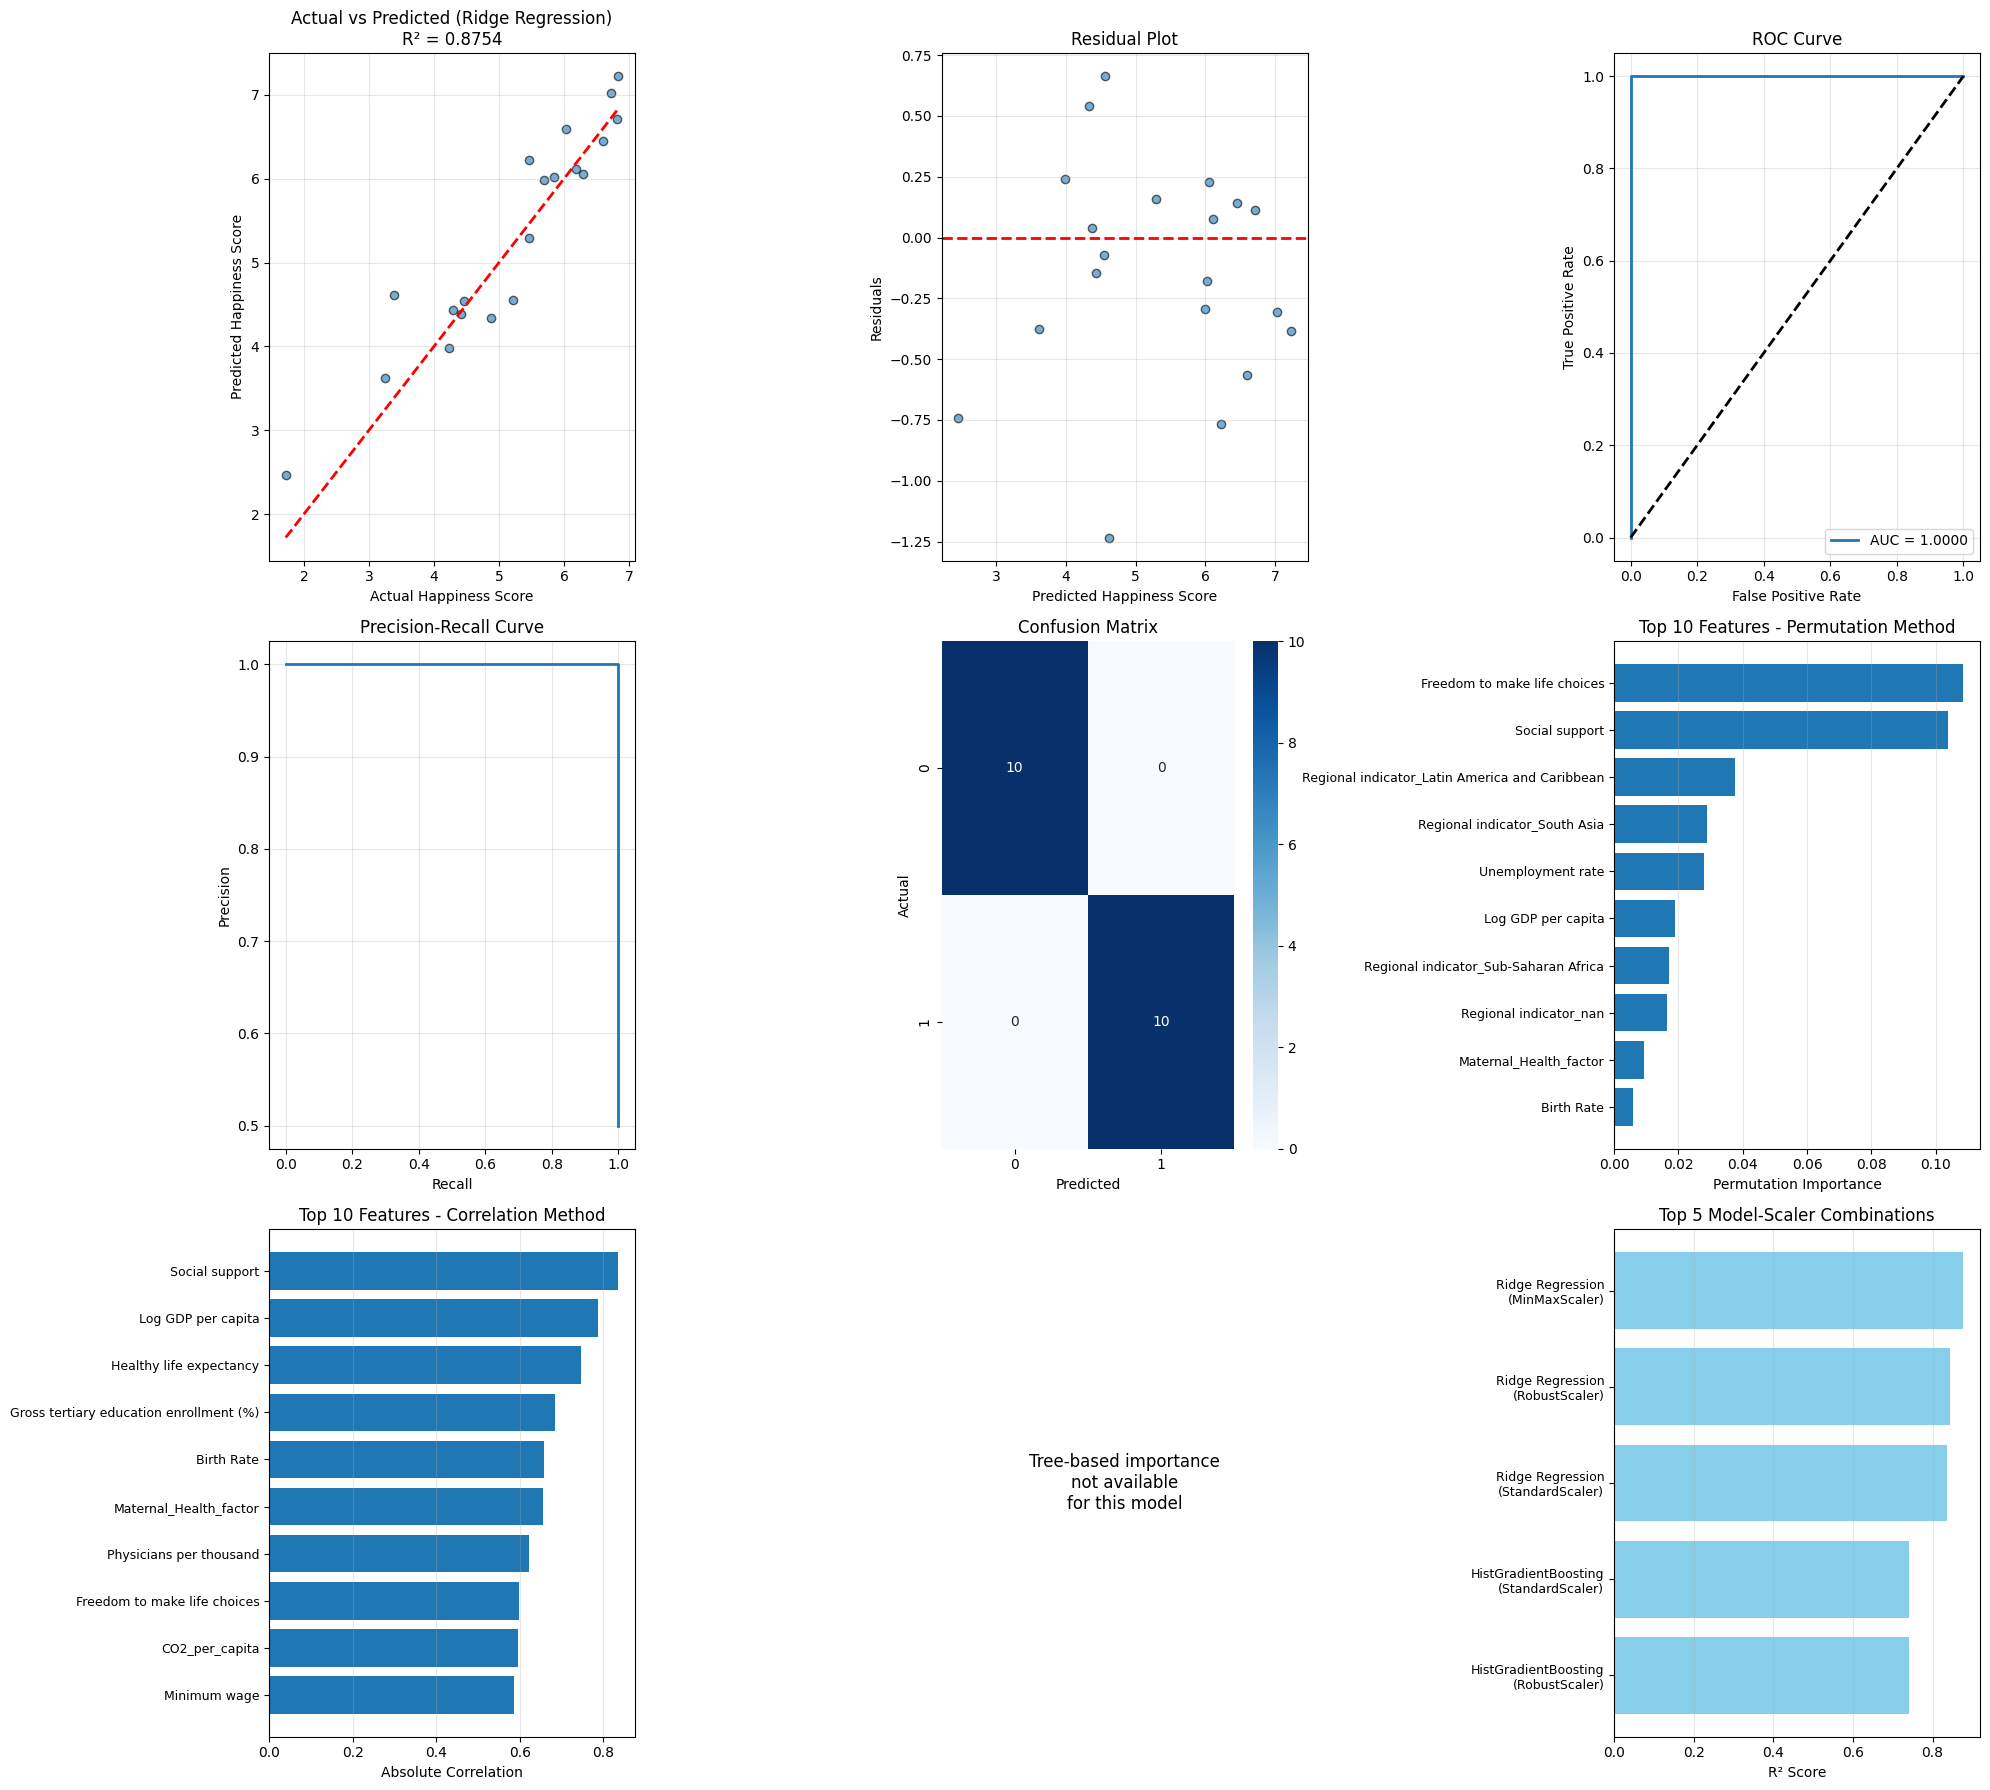

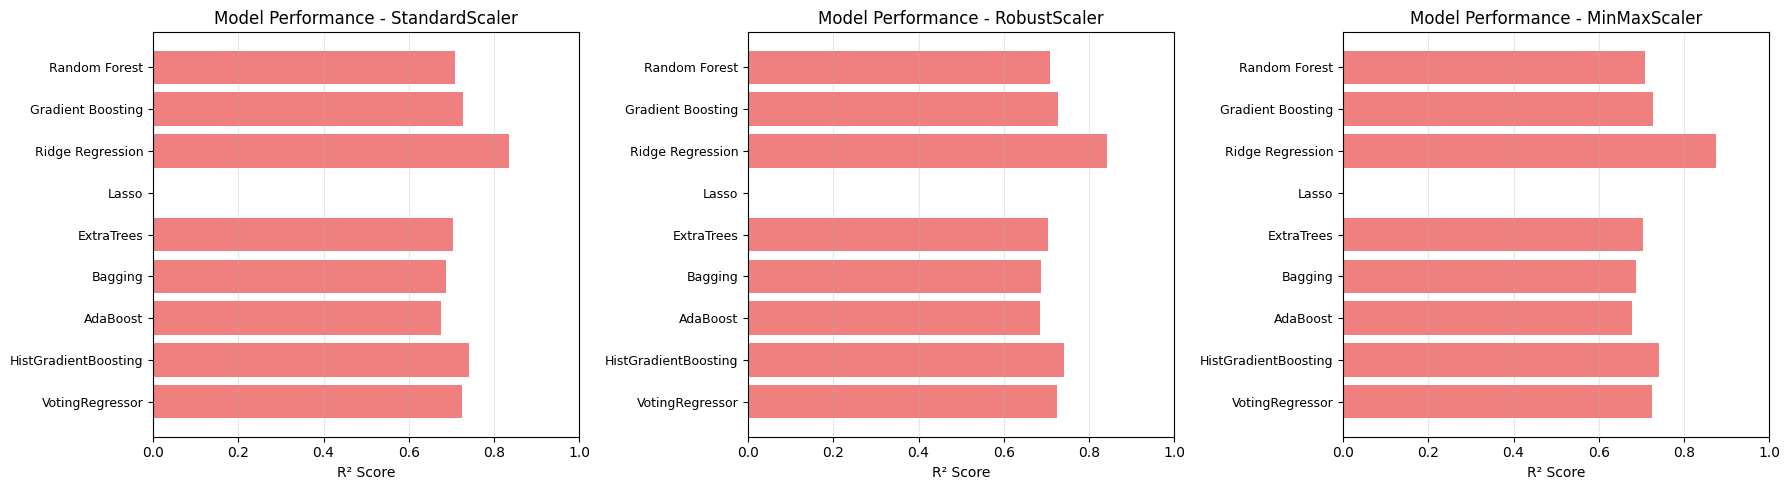


ANALYSIS COMPLETE


In [6]:
# =============================
# STEP 6 - ACTUAL ML MODEL
# =============================
selected_features = [col for col in world_merged_df.columns if col not in ['Country', 'Happiness']]

X = world_merged_df[selected_features]
y = world_merged_df['Happiness']

print(f"\nFeatures selected: {len(selected_features)}")
print(f"Target variable: Happiness")

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MULTIPLE SCALERS
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler()
}

# SCALE DATA WITH ALL SCALERS
scaled_data = {}
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_data[scaler_name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled
    }

# MODEL TRAINING & EVALUATION

models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0, random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=200, max_depth=10, random_state=42),
    'Bagging': BaggingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(max_iter=150, learning_rate=0.1, random_state=42)
}

# Create Voting Regressor
voting_reg = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, random_state=42)),
    ('et', ExtraTreesRegressor(n_estimators=200, max_depth=10, random_state=42))
])
models['VotingRegressor'] = voting_reg

best_model = None
best_score = -np.inf
best_scaler_name = None
results = {}

print("\n" + "="*60)
print("MODEL COMPARISON ACROSS DIFFERENT SCALERS")
print("="*60)

for scaler_name, scaler_data in scaled_data.items():
    print(f"\n{'='*60}")
    print(f"SCALER: {scaler_name}")
    print(f"{'='*60}")

    X_train_scaled = scaler_data['X_train']
    X_test_scaled = scaler_data['X_test']

    for name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Regression metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

        key = f"{scaler_name}_{name}"
        results[key] = {'model': model, 'y_pred': y_pred, 'r2': r2, 'rmse': rmse,
                       'scaler': scaler_name, 'model_name': name}

        print(f"\n{name}:")
        print(f"  MSE:  {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R² Score: {r2:.4f}")
        print(f"  CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        if r2 > best_score:
            best_score = r2
            best_model = model
            best_model_name = name
            best_y_pred = y_pred
            best_scaler_name = scaler_name
            best_X_test_scaled = X_test_scaled

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name} with {best_scaler_name} (R² = {best_score:.4f})")
print(f"{'='*60}")

# CLASSIFICATION METRICS

threshold = y_test.median()
y_pred_class = (best_y_pred >= threshold).astype(int)
y_test_class = (y_test >= threshold).astype(int)

acc = accuracy_score(y_test_class, y_pred_class)
prec = precision_score(y_test_class, y_pred_class, zero_division=0)
rec = recall_score(y_test_class, y_pred_class, zero_division=0)
f1 = f1_score(y_test_class, y_pred_class, zero_division=0)
cm = confusion_matrix(y_test_class, y_pred_class)

print("\n" + "="*60)
print("CLASSIFICATION METRICS (Binary: Above/Below Median Happiness)")
print("="*60)
print(f"Threshold: {threshold:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"\nConfusion Matrix:")
print(cm)
print(f"\nClassification Report:")
print(classification_report(y_test_class, y_pred_class, target_names=['Below Median', 'Above Median']))

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test_class, best_y_pred)
roc_auc = roc_auc_score(y_test_class, best_y_pred)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# FEATURE IMPORTANCE - CORRELATION BASED
print("\n" + "="*60)
print("FEATURE IMPORTANCE - CORRELATION WITH TARGET")
print("="*60)

correlation_importance = pd.DataFrame({
    'Feature': selected_features,
    'Correlation': [world_merged_df[feature].corr(y) for feature in selected_features],
    'Abs_Correlation': [abs(world_merged_df[feature].corr(y)) for feature in selected_features]
}).sort_values('Abs_Correlation', ascending=False)

print(correlation_importance.to_string(index=False))

# FEATURE IMPORTANCE - PERMUTATION METHOD
print("\n" + "="*60)
print("FEATURE IMPORTANCE - PERMUTATION METHOD")
print("="*60)

perm_importance = permutation_importance(best_model, best_X_test_scaled, y_test,
                                         n_repeats=30, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

print(perm_importance_df.to_string(index=False))

# FEATURE IMPORTANCE - TREE-BASED (if available)
if hasattr(best_model, 'feature_importances_'):
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE - TREE-BASED (Built-in)")
    print("="*60)

    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(feature_importance.to_string(index=False))

# VISUALIZATIONS

fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, best_y_pred, alpha=0.6, edgecolors='k')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Happiness Score')
axes[0, 0].set_ylabel('Predicted Happiness Score')
axes[0, 0].set_title(f'Actual vs Predicted ({best_model_name})\nR² = {best_score:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot
residuals = y_test - best_y_pred
axes[0, 1].scatter(best_y_pred, residuals, alpha=0.6, edgecolors='k')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Happiness Score')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. ROC Curve
axes[0, 2].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', lw=2)
axes[0, 2].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('ROC Curve')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test_class, best_y_pred)
axes[1, 0].plot(recall_vals, precision_vals, lw=2)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].grid(True, alpha=0.3)

# 5. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Confusion Matrix')

# 6. Permutation Feature Importance
top_perm_features = perm_importance_df.head(10)
axes[1, 2].barh(range(len(top_perm_features)), top_perm_features['Importance_Mean'])
axes[1, 2].set_yticks(range(len(top_perm_features)))
axes[1, 2].set_yticklabels(top_perm_features['Feature'], fontsize=9)
axes[1, 2].set_xlabel('Permutation Importance')
axes[1, 2].set_title('Top 10 Features - Permutation Method')
axes[1, 2].invert_yaxis()
axes[1, 2].grid(axis='x', alpha=0.3)

# 7. Correlation-Based Feature Importance
top_corr_features = correlation_importance.head(10)
axes[2, 0].barh(range(len(top_corr_features)), top_corr_features['Abs_Correlation'])
axes[2, 0].set_yticks(range(len(top_corr_features)))
axes[2, 0].set_yticklabels(top_corr_features['Feature'], fontsize=9)
axes[2, 0].set_xlabel('Absolute Correlation')
axes[2, 0].set_title('Top 10 Features - Correlation Method')
axes[2, 0].invert_yaxis()
axes[2, 0].grid(axis='x', alpha=0.3)

# 8. Tree-Based Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    top_tree_features = feature_importance.head(10)
    axes[2, 1].barh(range(len(top_tree_features)), top_tree_features['Importance'])
    axes[2, 1].set_yticks(range(len(top_tree_features)))
    axes[2, 1].set_yticklabels(top_tree_features['Feature'], fontsize=9)
    axes[2, 1].set_xlabel('Importance')
    axes[2, 1].set_title('Top 10 Features - Tree-Based Method')
    axes[2, 1].invert_yaxis()
    axes[2, 1].grid(axis='x', alpha=0.3)
else:
    axes[2, 1].text(0.5, 0.5, 'Tree-based importance\nnot available\nfor this model',
                    ha='center', va='center', fontsize=12)
    axes[2, 1].axis('off')

# 9. Model Performance Comparison (Top 5 Models by R²)
top_results = sorted(results.items(), key=lambda x: x[1]['r2'], reverse=True)[:5]
top_model_names = [f"{r[1]['model_name']}\n({r[1]['scaler']})" for r in top_results]
top_r2_scores = [r[1]['r2'] for r in top_results]

axes[2, 2].barh(range(len(top_model_names)), top_r2_scores, color='skyblue')
axes[2, 2].set_yticks(range(len(top_model_names)))
axes[2, 2].set_yticklabels(top_model_names, fontsize=9)
axes[2, 2].set_xlabel('R² Score')
axes[2, 2].set_title('Top 5 Model-Scaler Combinations')
axes[2, 2].invert_yaxis()
axes[2, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# MODEL COMPARISON CHART - BY SCALER

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, scaler_name in enumerate(scalers.keys()):
    scaler_results = {k: v for k, v in results.items() if v['scaler'] == scaler_name}
    model_names = [v['model_name'] for v in scaler_results.values()]
    r2_scores = [v['r2'] for v in scaler_results.values()]

    axes[idx].barh(range(len(model_names)), r2_scores, color='lightcoral')
    axes[idx].set_yticks(range(len(model_names)))
    axes[idx].set_yticklabels(model_names, fontsize=9)
    axes[idx].set_xlabel('R² Score')
    axes[idx].set_title(f'Model Performance - {scaler_name}')
    axes[idx].set_xlim([0, 1])
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

STEP 7: Probability & Statistics (World Happiness)

Columns available: ['Country', 'Delta_2013_2023', 'Density\n(P/Km2)', 'Agricultural Land( %)', 'Birth Rate', 'Armed Forces size', 'Forested Area (%)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Minimum wage', 'Out of pocket health expenditure', 'Physicians per thousand', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate', 'Unemployment rate', 'Happiness', 'Perceptions of corruption', 'Freedom to make life choices', 'Generosity', 'Log GDP per capita', 'Social support', 'Healthy life expectancy', 'Delta_c02_per_capita_2013_2023', 'CO2_per_capita', 'Maternal_Health_factor', 'Region'] 

P(Happiness > 6.0) ≈ 0.4000

Happiness ≈ Normal(μ=5.496, σ=1.162)



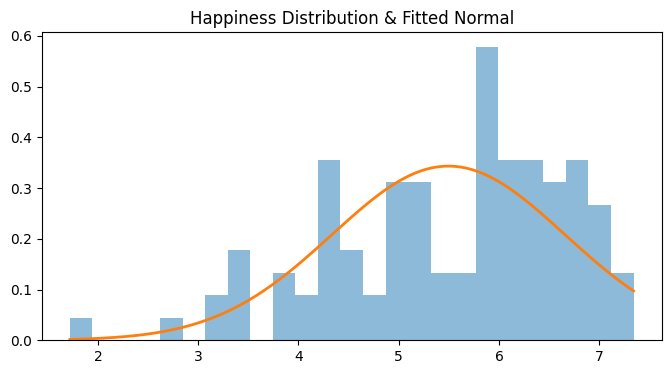

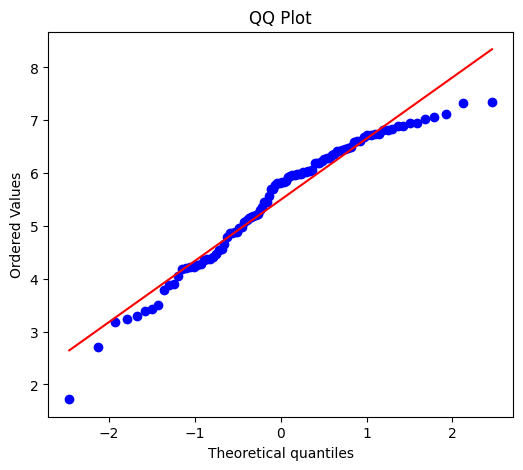

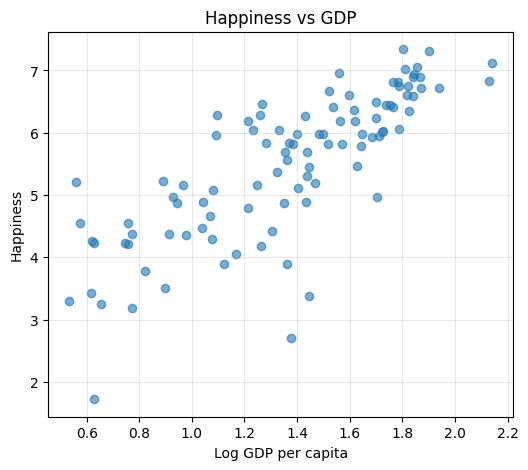

Spearman ρ=0.817, p=3.924e-25
Pearson r=0.788, p=2.394e-22

Chebyshev (k=2): bound=0.250, empirical=0.020



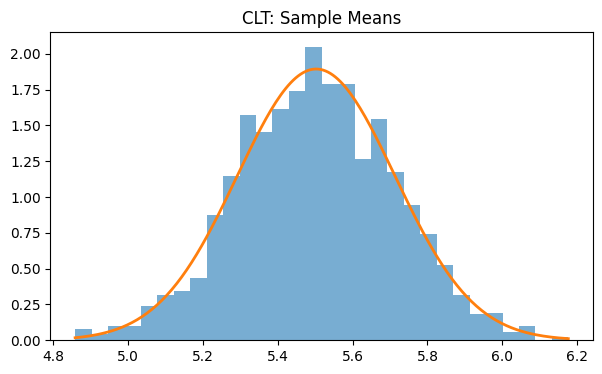

Means: mean=5.5022, std=0.2107

MGF Estimates:
  M(-0.2) ≈ 0.3428
  M(-0.1) ≈ 0.5812
  M(0.0) ≈ 1.0000
  M(0.1) ≈ 1.7439
  M(0.2) ≈ 3.0793


Normal MLE: μ=5.4957, σ=1.1617
Exponential MLE: λ=0.1820

95% CI for mean Happiness: [5.2640, 5.7273]

T-test: Sub-Saharan Africa vs Latin America and Caribbean
  t = -11.160, p = 5.333e-13

Z-test (μ=5.5): Z=-0.037, p=9.703e-01

Chi-square: chi2=14.935, p=1.344e-01

Bonferroni corrected p-values:
  Log GDP per capita: p=2.394e-22, corrected=1.197e-21
  Social support: p=4.724e-27, corrected=2.362e-26
  Healthy life expectancy: p=4.648e-19, corrected=2.324e-18
  Freedom to make life choices: p=5.173e-11, corrected=2.586e-10
  Generosity: p=4.151e-01, corrected=1.000e+00

STEP 7 complete.

STEP 7 — INTERPRETATION & EXPLANATION

7.1 Probability of Happiness > 6
- This probability reflects the fraction of countries where measured Happiness exceeds 6.
- Interpretation: If P(Happiness > 6) = 0.4000, then approximately 40.00% of countries have high happ

In [ ]:
# =============================================================================
# STEP 7 — PROBABILITY & STATISTICS ANALYSIS (INTERLEAVED WITH INTERPRETATIONS)
# =============================================================================

df_stats = world_merged_df.copy()

# -----------------------------------------------------------------------------
# Region Reconstruction
# -----------------------------------------------------------------------------
one_hot_cols = [c for c in df_stats.columns if c.startswith('Regional indicator_')]

def decode_region(row):
    for col in one_hot_cols:
        if row[col] == 1:
            return col.replace('Regional indicator_', '')
    return "Unknown"

df_stats['Region'] = df_stats.apply(decode_region, axis=1)
df_stats = df_stats.drop(columns=one_hot_cols)

print("STEP 7: Probability & Statistics (World Happiness)\n")
print("Columns available:", df_stats.columns.tolist(), "\n")

X = df_stats['Happiness'].dropna()


# =============================================================================
# 7.1 BASIC PROBABILITY
# =============================================================================
threshold = 6.0
prob_happy_gt = np.mean(X > threshold)
print(f"\n7.1 Probability → P(Happiness > {threshold}) ≈ {prob_happy_gt:.4f}")

# --- Interpretation ---
print("Interpretation:")
print(f"- Fraction of countries with Happiness above 6.")
print(f"- About {prob_happy_gt*100:.2f}% of countries score highly on Happiness.\n")


# =============================================================================
# 7.2 NORMAL FIT + QQ PLOT
# =============================================================================
h = X.values
mu_h, sigma_h = stats.norm.fit(h)
print(f"7.2 Normal Fit → Happiness ≈ Normal(μ={mu_h:.3f}, σ={sigma_h:.3f})")

plt.figure(figsize=(8,4))
plt.hist(h, bins=25, density=True, alpha=0.5)
xx = np.linspace(h.min(), h.max(), 200)
plt.plot(xx, stats.norm.pdf(xx, mu_h, sigma_h), lw=2)
plt.title('Happiness Distribution & Fitted Normal')
plt.show()

plt.figure(figsize=(6,5))
stats.probplot(h, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

# --- Interpretation ---
print("Interpretation:")
print("- The Normal curve overlaid on the histogram shows how well Happiness fits a Gaussian.")
print("- QQ plot alignment = stronger Normality.\n")


# =============================================================================
# 7.3 GDP–HAPPINESS CORRELATION
# =============================================================================
df_tmp = df_stats[['Log GDP per capita','Happiness']].dropna()

plt.figure(figsize=(6,5))
plt.scatter(df_tmp['Log GDP per capita'], df_tmp['Happiness'], alpha=0.6)
plt.xlabel('Log GDP per capita')
plt.ylabel('Happiness')
plt.title('Happiness vs GDP')
plt.grid(alpha=0.3)
plt.show()

rho, p_rho = stats.spearmanr(df_tmp['Log GDP per capita'], df_tmp['Happiness'])
pearson_r, p_pearson = stats.pearsonr(df_tmp['Log GDP per capita'], df_tmp['Happiness'])

print(f"7.3 Correlation → Spearman ρ={rho:.3f}, p={p_rho:.3e}")
print(f"                Pearson r={pearson_r:.3f}, p={p_pearson:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Positive correlation: richer countries tend to be happier.")
print("- Pearson = linear strength, Spearman = monotonic strength.")
print("- Very small p-values → strong statistical significance.\n")


# =============================================================================
# 7.4 CHEBYSHEV INEQUALITY
# =============================================================================
mu_x = X.mean()
sigma_x = X.std(ddof=0)
k = 2
cheb_bound = 1.0 / (k**2)
empirical = np.mean(np.abs(X - mu_x) >= k * sigma_x)

print(f"7.4 Chebyshev → bound={cheb_bound:.3f}, empirical={empirical:.3f}")

# --- Interpretation ---
print("Interpretation:")
print("- Chebyshev gives a universal bound for ANY distribution.")
print("- Empirical proportion < bound → Chebyshev holds easily.\n")


# =============================================================================
# 7.5 CENTRAL LIMIT THEOREM (BOOTSTRAP SAMPLE MEANS)
# =============================================================================
sample_size = 30
n_experiments = 2000

means = np.array([
    X.sample(sample_size, replace=True, random_state=i).mean()
    for i in range(n_experiments)
])

plt.figure(figsize=(7,4))
plt.hist(means, bins=30, density=True, alpha=0.6)
xx = np.linspace(means.min(), means.max(), 200)
plt.plot(xx, stats.norm.pdf(xx, means.mean(), means.std()), lw=2)
plt.title('CLT: Sample Means')
plt.show()

print(f"7.5 CLT → mean={means.mean():.4f}, std={means.std():.4f}")

# --- Interpretation ---
print("Interpretation:")
print("- Distribution of sample means looks Normal (CLT in action).")
print("- Even if raw data isn't perfectly Normal, means converge.\n")


# =============================================================================
# 7.6 EMPIRICAL MGF
# =============================================================================
t_values = [-0.2, -0.1, 0.0, 0.1, 0.2]
mgf_values = {t: np.mean(np.exp(t * X)) for t in t_values}

print("7.6 MGF Estimates:")
for t, v in mgf_values.items():
    print(f"  M({t}) ≈ {v:.4f}")

# --- Interpretation ---
print("Interpretation:")
print("- MGF values characterize all moments of the distribution.")
print("- Shows how E[e^{tX}] behaves for positive/negative t.\n")


# =============================================================================
# 7.7 MAXIMUM LIKELIHOOD ESTIMATION
# =============================================================================
mu_mle = X.mean()
sigma_mle = X.std(ddof=0)

print(f"7.7 Normal MLE → μ={mu_mle:.4f}, σ={sigma_mle:.4f}")

if (X > 0).all():
    print(f"Exponential MLE → λ={1/X.mean():.4f}")
else:
    print("Exponential MLE → skipped (non-positive values)")

# --- Interpretation ---
print("Interpretation:")
print("- For a Normal distribution: μ̂ = sample mean, σ̂ = sample std.")
if (X > 0).all():
    print("- For exponential: λ̂ = 1 / mean.")
print()


# =============================================================================
# 7.8 95% CONFIDENCE INTERVAL
# =============================================================================
mean_h = X.mean()
sem_h = stats.sem(X)
ci_low, ci_high = stats.t.interval(0.95, df=len(X)-1, loc=mean_h, scale=sem_h)

print(f"7.8 95% CI → [{ci_low:.4f}, {ci_high:.4f}]")

# --- Interpretation ---
print("Interpretation:")
print("- 95% of intervals constructed this way would contain the true mean.")
print("- CI provides a range estimate for global Happiness.\n")


# =============================================================================
# 7.9 REGION-BASED T-TEST (TOP 2 REGIONS)
# =============================================================================
region_counts = df_stats['Region'].value_counts()
top2 = region_counts.index[:2]

g1 = df_stats.loc[df_stats['Region'] == top2[0], 'Happiness'].dropna()
g2 = df_stats.loc[df_stats['Region'] == top2[1], 'Happiness'].dropna()

t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
print(f"7.9 T-test → {top2[0]} vs {top2[1]}: t={t_stat:.3f}, p={p_val:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Tests if the two most common regions differ in Happiness.")
print("- Small p-value → significant regional difference.\n")


# =============================================================================
# 7.10 Z-TEST AGAINST 5.5
# =============================================================================
pop_ref = 5.5
z_stat = (X.mean() - pop_ref) / (X.std(ddof=1) / np.sqrt(len(X)))
p_z = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"7.10 Z-test → Z={z_stat:.3f}, p={p_z:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Tests whether world mean Happiness = 5.5.")
print("- Small p → mean differs significantly from 5.5.\n")


# =============================================================================
# 7.11 CHI-SQUARE TEST (REGION × CORRUPTION)
# =============================================================================
tmp = df_stats[['Region', 'Perceptions of corruption']].dropna()
tmp['HighCorruption'] = (tmp['Perceptions of corruption'] >
                         tmp['Perceptions of corruption'].median()).astype(int)

ct = pd.crosstab(tmp['Region'], tmp['HighCorruption'])
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)

print(f"7.11 Chi-square → chi2={chi2:.3f}, p={p_chi:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Tests independence between Region and Corruption.")
print("- Significant p → corruption varies meaningfully by region.\n")


# =============================================================================
# 7.12 BONFERRONI MULTIPLE TESTING
# =============================================================================
features = [
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy',
    'Freedom to make life choices',
    'Generosity'
]

pvals, names = [], []

for feat in features:
    df_tmp = df_stats[[feat, 'Happiness']].dropna()
    r, p = stats.pearsonr(df_tmp[feat], df_tmp['Happiness'])
    pvals.append(p)
    names.append(feat)

corrected = np.minimum(np.array(pvals) * len(pvals), 1.0)

print("7.12 Bonferroni Correction:")
for f, p_orig, p_corr in zip(names, pvals, corrected):
    print(f"  {f}: p={p_orig:.3e}, corrected={p_corr:.3e}")

# --- Interpretation ---
print("Interpretation:")
print("- Bonferroni guards against false positives from multiple tests.")
print("- Features with small corrected p remain truly significant.\n")

print("STEP 7 complete.\n")